# Do climate targets enforce themselves via climate damages?
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from scipy import stats

Data inputs

In [2]:
loc_ssp_iam = "../Data/SSP/"
loc_emissions = "../Data/GlobalCarbonBudget/"
loc_deflator = "../Data/GDPDeflator/" 

#### Parameters

TCRE

In [3]:
tcre = 0.48 # degrees C per 1000 GtCO2 of cumulative CO2 emissions
# a distribution!
# from arora et al biogeosciences
tcre_list = np.array([0.55,0.36,0.57,0.58,0.44,0.58,\
                      0.38,0.45,0.4,0.36,0.63])
np.random.seed(100)
nboot = 100 # bootstrap
tcre_dist = np.zeros(nboot)
for i in np.arange(0,nboot,1):
    tcre_sample = np.random.choice(np.arange(0,len(tcre_list),1),size=len(tcre_list),replace=True)
    tcre_dist[i] = np.mean(tcre_list[np.array(tcre_sample)])
tcre_dist_old = np.sort(np.array([np.around(x,5) for x in tcre_dist]))
#tcre_dist = np.arange(np.amin(tcre_list),np.amax(tcre_list)+0.005,0.005)

## or the ipcc
## likely range of 1.0 - 2.3 degrees C per PgC
## best est of 1.65 degrees C per PgC or 0.45 per 1000 GtCO2
ipcc_range = [1.0/3.66,2.3/3.66] #0.27 - 0.63 -- 5-95% range or likely range
#tcre_dist_ipcc = np.random.uniform(low=ipcc_range[0],high=ipcc_range[1],size=nboot)
tcre_dist_ipcc = np.random.normal(loc=0.45,scale=0.11,size=nboot*2)
pct17 = np.percentile(tcre_dist_ipcc,17)
pct83 = np.percentile(tcre_dist_ipcc,83)
pct5 = np.percentile(tcre_dist_ipcc,5)
pct95 = np.percentile(tcre_dist_ipcc,95)
print("66% range of TCRE is "+str(np.around(pct17,3))+"-"+str(np.around(pct83,3)))
print("90% range of TCRE is "+str(np.around(pct5,3))+"-"+str(np.around(pct95,3)))
# truncate at 0.27 - 0.63?
#tcre_dist = tcre_dist_ipcc[(tcre_dist_ipcc>=ipcc_range[0])&(tcre_dist_ipcc<=ipcc_range[1])]

tcre_dist = np.arange(np.around(np.amin(ipcc_range[0]),3),np.around(np.amax(ipcc_range[1]),3)+0.005,0.005)

66% range of TCRE is 0.345-0.549
90% range of TCRE is 0.248-0.62


Time period

In [4]:
y1 = 2020
y2 = 2100
years = np.arange(y1,y2+1,1)

#### Functions

Function for loading SSP data and calculating quantities for Kaya Identity

In [5]:
def load_ssp_data(scenario,subset,mdl,years):
    # load data for desired variables, interpolate to yearly timestep
    
    var = ["Population","Emissions|CO2","GDP|PPP","Final Energy"]
    vname = ["population","emissions","gdp","energy"]

    # scenario name, load
    scenario_nm = scenario+"-"+subset
    data_in = pd.read_csv(loc_ssp_iam+"SSP_IAM_V2_201811.csv")
    data = data_in.loc[(data_in.SCENARIO==scenario_nm)&(data_in.REGION=="World")&(data_in.MODEL==mdl),:]
    
    # build dataframe
    df_orig = pd.DataFrame({"year":years,"population":np.full(len(years),np.nan),
                  "gdp":np.full(len(years),np.nan),"energy":np.full(len(years),np.nan),
                  "emissions":np.full(len(years),np.nan)})
    
    # load each variable
    for v in var:
        vn = vname[var.index(v)]
        data_v = data.loc[data.VARIABLE.values==v,:]
        yrs_v = data_v.iloc[:,7:].columns.values.astype(int) # index 7 because 2020
        data_v_vals = data_v.iloc[:,7:].values[0] # index 7 because 2020
        df_ind = [x in yrs_v for x in df_orig.year.values]
        df_orig.loc[df_ind,vn] = data_v_vals
    
    # convert US 2005 to US 2020
    gdp_deflator = pd.read_csv(loc_deflator+"API_NY.GDP.DEFL.ZS_DS2_en_excel_v2_4353530.csv")
    usa_deflator = gdp_deflator.loc[gdp_deflator["Country Code"]=="USA",:]
    deflator_2020_2005 = usa_deflator.loc[:,"2020"].values[0]/usa_deflator.loc[:,"2005"].values[0]
    df_orig["gdp"] = df_orig.gdp.values*deflator_2020_2005
    
    # Interpolate to yearly time step linearly
    df = df_orig.interpolate(method="polynomial",axis=0,order=2)
    
    # unit conversion
    df["emissions"] = df["emissions"]/1000.0 # mt co2/yr to gt co2/yr
    df["gdp"] = df["gdp"]/1000.0 # billion 2005 to trillion 2005
    df["population"] = df["population"]/1000.0 # million to billion
    
    # GDP growth
    df["gdp_growth"] = df.gdp.diff()/df.gdp.shift(periods=1)
    
    # kaya identity values
    df["e_g"] = df["energy"]/df["gdp"]
    df["f_e"] = df["emissions"]/df["energy"]
    df["g_p"] = df["gdp"]/df["population"]
    df["emissions_kaya"] = df.population * df.g_p * df.e_g * df.f_e
    
    return(df)

Main code for model

In [6]:
def model_growth_damages(years,initial_gdp,initial_emissions,initial_dt,
                         tcre,damage_coefs,pop_list,e_g_list,f_e_list,growth_list):
    
    # years: time over to which to run model
    # initial_gdp: world GDP in 2020 in trillions USD
    # initial_emissions: *cumulative* emissions in 2020 in GtCO2
    # initial_dt: temperature change relative to pre-industrial in 2020
    # tcre: transient climate response to cumulative emissions in degrees C per 1000 GtCO2 cumulative
    # damage_coefs: damage function coefficients, in a list: intercept, linear, quadratic, cubic
    # pop_list: exogenous population over the years desired
    # e_g_list: exogenous energy intensity of GDP 
    # f_e_list: exogenous emissions intensity of energy (but can be modified by mitigation)
    # growth_list: exogenous baseline (non-damaged) rate of economic growth
    
    # requires xarray, numpy, sys
        
    gdp_out = xr.DataArray(np.full(len(years),np.nan),coords=[years],dims=["time"])
    emissions_out = xr.DataArray(np.full(len(years),np.nan),coords=[years],dims=["time"])
    deltat_out = xr.DataArray(np.full(len(years),np.nan),coords=[years],dims=["time"])
    
    gdp_out[0] = initial_gdp
    emissions_out[0] = initial_emissions
    deltat_out[0] = initial_dt
    
    # damage function coefs
    # in percents -- 2% should be in damage_coefs as 2, not 0.02
    coef0 = damage_coefs[0]/100.0
    coef1 = damage_coefs[1]/100.0
    coef2 = damage_coefs[2]/100.0
    coef3 = damage_coefs[3]/100.0
    
    for i in np.arange(1,len(years),1):
        year = years[i]

        # exogenous vals 
        pop = pop_list[i]
        e_g = e_g_list[i]
        f_e = f_e_list[i]
        gr = growth_list[i]

        # iterate
        gdp_nodamage = gdp_out[i-1] + (gdp_out[i-1]*gr)
        
        # take cumulative emissions from the previous year as the tcre input to year t
        emissions_prev = emissions_out[i-1] # for input to tcre
        
        # calculate delta t
        deltat_out[i] = emissions_prev*(tcre/1000.0)
        
        # damages to growth rate in percent
        damages = coef3*(deltat_out[i]**3) + coef2*(deltat_out[i]**2) + (coef1*deltat_out[i]) + coef0
        
        # gdp with damages
        gdp_out[i] = gdp_out[i-1] + (gdp_out[i-1]*(gr-damages))
        
        # *cumulative* emissions as a result of gdp
        emissions_out[i] = (pop * (gdp_out[i]/pop) * (e_g) * (f_e)) + emissions_out[i-1]
        
    return([gdp_out,emissions_out,deltat_out])


def model_weitzman_damages(years,initial_gdp,initial_emissions,initial_dt,tcre,
                         damage_coefs,pop_list,e_g_list,f_e_list,growth_list,gdp_list):
    
    # years: time over to which to run model
    # initial_gdp: world GDP in 2020 in trillions USD
    # initial_emissions: *cumulative* emissions in 2020 in GtCO2
    # initial_dt: temperature change relative to pre-industrial in 2020
    # tcre: transient climate response to cumulative emissions in degrees C per 1000 GtCO2 cumulative
    # damage_coefs: damage function coefficients, in a list: intercept, linear, quadratic, additional exponent
    # pop_list: exogenous population over the years desired
    # e_g_list: exogenous energy intensity of GDP 
    # f_e_list: exogenous emissions intensity of energy (but can be modified by mitigation)
    # growth_list: exogenous baseline (non-damaged) rate of economic growth
    # gdp_list: exogenous baseline (non-damaged) GDP 
    
    # requires xarray, numpy, sys
        
    gdp_out = xr.DataArray(np.full(len(years),np.nan),coords=[years],dims=["time"])
    emissions_out = xr.DataArray(np.full(len(years),np.nan),coords=[years],dims=["time"])
    deltat_out = xr.DataArray(np.full(len(years),np.nan),coords=[years],dims=["time"])
    
    gdp_out[0] = initial_gdp
    emissions_out[0] = initial_emissions
    deltat_out[0] = initial_dt
    
    # damage function coefs
    # in percents -- 2% should be in damage_coefs as 2, not 0.02
    coef0 = damage_coefs[0]/100.0
    coef1 = damage_coefs[1]/100.0
    coef2 = damage_coefs[2]/100.0
    coef3 = damage_coefs[3]/100.0
    
    for i in np.arange(1,len(years),1):
        year = years[i]

        # exogenous vals 
        pop = pop_list[i]
        e_g = e_g_list[i]
        f_e = f_e_list[i]
        gr = growth_list[i]
        gdp_nodamage = gdp_list[i]

        # iterate
        
        # take cumulative emissions from the previous year as the tcre input to year t
        emissions_prev = emissions_out[i-1] # for input to tcre
        
        # calculate delta t
        deltat_out[i] = emissions_prev*(tcre/1000.0)
        
        # damages to growth rate in percent
        damages = 1 - 1/(1 + coef3*(deltat_out[i]**6.754) + coef2*(deltat_out[i]**2) + (coef1*deltat_out[i]) + coef0)
        
        # gdp with damages
        gdp_out[i] = gdp_nodamage - (gdp_nodamage*damages)
        
        # *cumulative* emissions as a result of gdp
        emissions_out[i] = (pop * (gdp_out[i]/pop) * (e_g) * (f_e)) + emissions_out[i-1]
        
    return([gdp_out,emissions_out,deltat_out])

#### Analysis

Load Global Carbon Budget data so we have cumulative emissions from 1850

In [7]:
gcp = pd.read_csv(loc_emissions+"GlobalCarbonBudget_HistoricalEmissions.csv")
gcp = gcp.loc[gcp.Year>=1850,:].reset_index().drop(columns="index")
gcp["total_emissions_gtc"] = gcp["fossil emissions excluding carbonation GtC"] + gcp["land-use change emissions GtC"]
gcp["total_emissions_gtco2"] = gcp.total_emissions_gtc*3.664
gcp["cumulative_emissions_gtco2"] = np.cumsum(gcp.total_emissions_gtco2.values)
gcp["obs_temp_change"] = gcp.cumulative_emissions_gtco2.shift(periods=1)/1000.0 * tcre

Now load SSP data for desired scenario

In [8]:
main_scenario = "SSP2"
scenario_subset = "Baseline" #Baseline, 19 for SSP1-19, 26 for SSP2-26, etc.
benchmark_mdls = {"SSP1":"IMAGE","SSP2":"MESSAGE-GLOBIOM",
                 "SSP3":"AIM/CGE","SSP4":"GCAM4","SSP5":"REMIND-MAGPIE"}
rcp_scenarios = {"SSP1":"26","SSP2":"45","SSP3":"34","SSP4":"60","SSP5":"60"}
main_mdl = benchmark_mdls[main_scenario]
data_main = load_ssp_data(main_scenario,rcp_scenarios[main_scenario],main_mdl,np.arange(y1,y2+1,1))

In [9]:
data_in = pd.read_csv(loc_ssp_iam+"SSP_IAM_V2_201811.csv")

In [10]:
np.unique(data_in.SCENARIO.values)

array(['SSP1-19', 'SSP1-26', 'SSP1-34', 'SSP1-45', 'SSP1-60',
       'SSP1-Baseline', 'SSP2-19', 'SSP2-26', 'SSP2-34', 'SSP2-45',
       'SSP2-60', 'SSP2-Baseline', 'SSP3-34', 'SSP3-45', 'SSP3-60',
       'SSP3-Baseline', 'SSP4-19', 'SSP4-26', 'SSP4-34', 'SSP4-45',
       'SSP4-60', 'SSP4-Baseline', 'SSP5-19', 'SSP5-26', 'SSP5-34',
       'SSP5-45', 'SSP5-60', 'SSP5-Baseline'], dtype=object)

Add cumulative emissions based on the GCP data

In [11]:
data_main["cumulative_emissions"] = np.cumsum(data_main["emissions"]) + gcp.loc[gcp.Year==(y1-1),"cumulative_emissions_gtco2"].values
#data_main["dt"] = data_main.cumulative_emissions/1000.0 * tcre

Now simulate a range of damage fractions

In [12]:
damage_coefs_0 = 0 # no intercept
damage_coefs_1 = np.array([np.around(x,2) for x in np.arange(0,1.2+0.05,0.05)])
damage_coefs_2 = 0 # quadratic
damage_coefs_3 = 0 # cubic
# using approximate values from Moore and Diaz (2015) 
# which calibrate DICE to the growht effects found by Dell, Jones, and Olken (2012)
# damages are expressed as percentage-point changes in growth
# as a function of temperature
# https://www.nature.com/articles/nclimate2481
# https://scholar.harvard.edu/files/dell/files/aej_temperature.pdf

In [13]:
years

array([2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030,
       2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041,
       2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052,
       2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063,
       2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074,
       2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085,
       2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096,
       2097, 2098, 2099, 2100])

In [14]:
gcp

,Year,fossil emissions excluding carbonation GtC,land-use change emissions GtC,total_emissions_gtc,total_emissions_gtco2,cumulative_emissions_gtco2,obs_temp_change
0,1850,0.05,0.69,0.74,2.71136,2.71136,NaN
1,1851,0.05,0.71,0.76,2.78464,5.49600,0.001301
2,1852,0.06,0.72,0.78,2.85792,8.35392,0.002638
3,1853,0.06,0.74,0.80,2.93120,11.28512,0.004010
4,1854,0.07,0.75,0.82,3.00448,14.28960,0.005417
...,...,...,...,...,...,...,...
166,2016,9.68,1.01,10.69,39.16816,2272.44944,1.071975
167,2017,9.80,1.00,10.80,39.57120,2312.02064,1.090776
168,2018,10.00,1.05,11.05,40.48720,2352.50784,1.109770
169,2019,10.02,1.04,11.06,40.52384,2393.03168,1.129204


In [15]:
gcp.loc[gcp.Year==2019,"cumulative_emissions_gtco2"].values[0]/1000.0 * np.mean(tcre_dist)

1.0780607718400006

In [16]:
gdp_simulated = xr.DataArray(np.full((len(years),len(damage_coefs_1)),np.nan),
                          coords=[years,damage_coefs_1],
                         dims=["time","damages"])
emissions_simulated = xr.DataArray(np.full((len(years),len(damage_coefs_1)),np.nan),
                          coords=[years,damage_coefs_1],
                         dims=["time","damages"])
temp_simulated = xr.DataArray(np.full((len(years),len(damage_coefs_1)),np.nan),
                          coords=[years,damage_coefs_1],
                         dims=["time","damages"])
gdp_init = data_main.loc[data_main.year==y1,"gdp"].values[0]
emiss_init = data_main.loc[data_main.year==y1,"cumulative_emissions"].values[0]
cumul_emissions = data_main.cumulative_emissions.values
dt_main = np.zeros(len(data_main.cumulative_emissions))
dt_main[0] = gcp.loc[gcp.Year==2019,"cumulative_emissions_gtco2"].values[0]/1000.0 * np.mean(tcre_dist)
for j in np.arange(1,len(dt_main),1):
    dt_main[j] = cumul_emissions[j-1]/1000.0 * np.mean(tcre_dist)
data_main["dt"] = dt_main
#data_main["dt"] = data_main.cumulative_emissions/1000.0 * np.mean(tcre_dist)
t_init = data_main.loc[data_main.year==y1,"dt"].values[0]

for d in damage_coefs_1:
    print(d)
    gdp_simulated.loc[:,d], emissions_simulated.loc[:,d], temp_simulated.loc[:,d] = model_growth_damages(
                                                years,gdp_init,emiss_init,
                                                t_init,np.mean(tcre_dist),[damage_coefs_0,d,damage_coefs_2,damage_coefs_3],
                                                data_main.population.values,data_main.e_g.values,
                                                data_main.f_e.values,data_main.gdp_growth.values)

0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
1.05
1.1
1.15
1.2


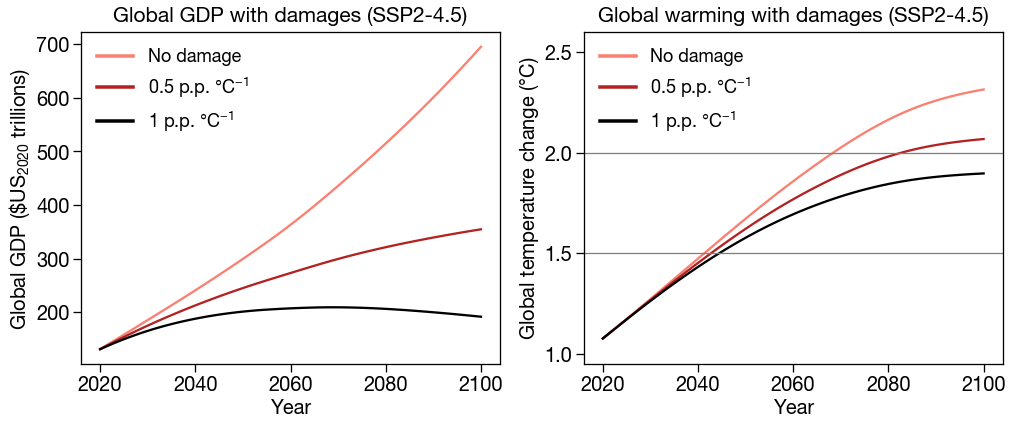

In [17]:
fig = plt.figure(figsize=(16,6))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

tfs = 21
lfs = 18
llw = 3.5

gs0 = gridspec.GridSpec(1,2)
gs0.update(left=0.13,right=0.93,top=0.92,bottom=0.15,wspace=0.2,hspace=0.33)


ax = plt.subplot(gs0[0,0])

col_no_dam = "salmon"
col_mid_dam = "firebrick"
col_max_dam = "black"

plt.plot(years,gdp_simulated.loc[:,0],label='No damage',linewidth=2.3,color=col_no_dam)
plt.plot(years,gdp_simulated.loc[:,0.5],label='0.5 p.p. $\degree$C$^{-1}$',
        linewidth=2.3,color=col_mid_dam)
plt.plot(years,gdp_simulated.loc[:,1],label='1 p.p. $\degree$C$^{-1}$',
        linewidth=2.3,color=col_max_dam)
plt.xlabel("Year")
plt.ylabel("Global GDP (\$US$_{2020}$ trillions)")
leg = plt.legend(loc="upper left",frameon=False,fontsize=lfs)
for line in leg.get_lines():
    line.set_linewidth(llw)

#plt.axhline(y=1.5,color="gray",linewidth=1.3)
#plt.axhline(y=2,color="gray",linewidth=1.3)

#plt.ylim([0.95,2.6])
#plt.yticks([1,1.5,2,2.5])
plt.title("Global GDP with damages (SSP2-4.5)",fontsize=tfs,pad=10)




ax = plt.subplot(gs0[0,1])

plt.plot(years,temp_simulated.loc[:,0],label='No damage',linewidth=2.3,color=col_no_dam)
plt.plot(years,temp_simulated.loc[:,0.5],label='0.5 p.p. $\degree$C$^{-1}$',
        linewidth=2.3,color=col_mid_dam)
plt.plot(years,temp_simulated.loc[:,1],label='1 p.p. $\degree$C$^{-1}$',
        linewidth=2.3,color=col_max_dam)
plt.xlabel("Year")
plt.ylabel("Global temperature change ($\degree$C)")
leg = plt.legend(loc="upper left",frameon=False,fontsize=lfs)
for line in leg.get_lines():
    line.set_linewidth(llw)

plt.axhline(y=1.5,color="gray",linewidth=1.3)
plt.axhline(y=2,color="gray",linewidth=1.3)

plt.ylim([0.95,2.6])
plt.yticks([1,1.5,2,2.5])
plt.title("Global warming with damages (SSP2-4.5)",fontsize=tfs,pad=10)

plt.show()

Run analysis for all SSPs

In [18]:
scenarios = ["SSP1","SSP2","SSP3","SSP4","SSP5"]
gdp_simulated_ssps = xr.DataArray(np.full((len(scenarios),len(years),len(damage_coefs_1)),np.nan),
                              coords=[scenarios,years,damage_coefs_1],
                                   dims=["scenario","time","damages"])
emissions_simulated_ssps = xr.DataArray(np.full((len(scenarios),len(years),len(damage_coefs_1)),np.nan),
                              coords=[scenarios,years,damage_coefs_1],
                                   dims=["scenario","time","damages"])
temp_simulated_ssps = xr.DataArray(np.full((len(scenarios),len(years),len(damage_coefs_1)),np.nan),
                              coords=[scenarios,years,damage_coefs_1],
                                   dims=["scenario","time","damages"])
gdp_main_ssps = xr.DataArray(np.full((len(scenarios),len(years)),np.nan),
                            coords=[scenarios,years],dims=["scenario","time"])
for s in scenarios:
    print(s)
    mdl = benchmark_mdls[s]
    data_s = load_ssp_data(s,rcp_scenarios[s],mdl,years)
    data_s["cumulative_emissions"] = np.cumsum(data_s["emissions"]) + gcp.loc[gcp.Year==(y1-1),"cumulative_emissions_gtco2"].values
    #data_s["dt"] = data_s.cumulative_emissions/1000.0 * tcre
    
    gdp_init = data_s.loc[data_s.year==y1,"gdp"].values[0]
    emiss_init = data_s.loc[data_s.year==y1,"cumulative_emissions"].values[0]
    cumul_emissions = data_s.cumulative_emissions.values
    dt_s = np.zeros(len(cumul_emissions))
    dt_s[0] = gcp.loc[gcp.Year==2019,"cumulative_emissions_gtco2"].values[0]/1000.0 * np.mean(tcre_dist)
    for j in np.arange(1,len(dt_s),1):
        dt_s[j] = cumul_emissions[j-1]/1000.0 * np.mean(tcre_dist)
    data_s["dt"] = dt_s
    t_init = data_s.loc[data_s.year==y1,"dt"].values[0]
    gdp_main_ssps.loc[s,:] = data_s.gdp.values
    
    for d in damage_coefs_1:
        gdp_simulated_ssps.loc[s,:,d], emissions_simulated_ssps.loc[s,:,d], temp_simulated_ssps.loc[s,:,d] = model_growth_damages(
                                            years,gdp_init,emiss_init,
                                            t_init,np.mean(tcre_dist),[damage_coefs_0,d,damage_coefs_2,damage_coefs_3],
                                            data_s.population.values,data_s.e_g.values,
                                            data_s.f_e.values,data_s.gdp_growth.values)

SSP1
SSP2
SSP3
SSP4
SSP5


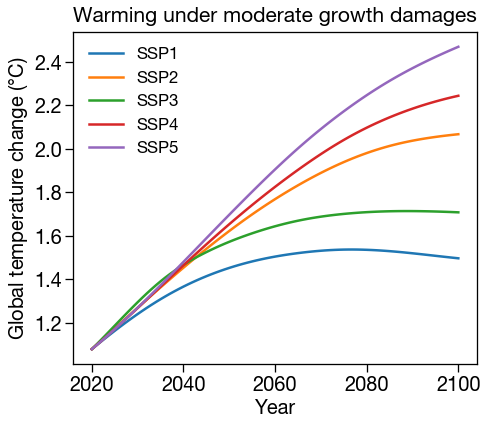

In [19]:
fig = plt.figure(figsize=(7,6))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

tfs = 21

gs0 = gridspec.GridSpec(1,1)
gs0.update(left=0.13,right=0.93,top=0.92,bottom=0.15,wspace=0.33,hspace=0.33)

ax = plt.subplot(gs0[0,0])

for x in ["SSP1","SSP2","SSP3","SSP4","SSP5"]:  
    plt.plot(years,temp_simulated_ssps.loc[x,:,0.5],label=x,linewidth=2.5)

plt.xlabel("Year")
plt.ylabel("Global temperature change ($\degree$C)")
plt.legend(loc="upper left",frameon=False,fontsize=17)
plt.title("Warming under moderate growth damages",fontsize=tfs,pad=10)


plt.show()

Comparing with and without damages

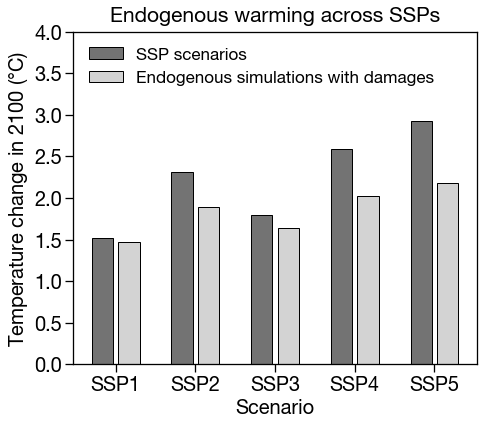

In [20]:
fig = plt.figure(figsize=(7,6))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

tfs = 21

gs0 = gridspec.GridSpec(1,1)
gs0.update(left=0.13,right=0.93,top=0.92,bottom=0.15,wspace=0.33,hspace=0.33)

ax = plt.subplot(gs0[0,0])

x1 = [1,4,7,10,13]
plt.bar(x1,height=temp_simulated_ssps.loc[:,2100,0].values,
       edgecolor="black",facecolor=np.array([0.45,0.45,0.45]),
        label="SSP scenarios")

x2 = [2,5,8,11,14]
plt.bar(x2,height=temp_simulated_ssps.loc[:,2100,1.0].values,
       edgecolor="black",facecolor="lightgray",
        label="Endogenous simulations with damages")

plt.xticks(ticks=(np.array(x2)+np.array(x1))/2,labels=scenarios)
plt.xlabel("Scenario")
plt.ylabel("Temperature change in 2100 ($\degree$C)")
plt.title("Endogenous warming across SSPs",fontsize=tfs,pad=10)
plt.legend(loc="upper left",fontsize=17,frameon=False)
plt.ylim([0,4])


plt.show()

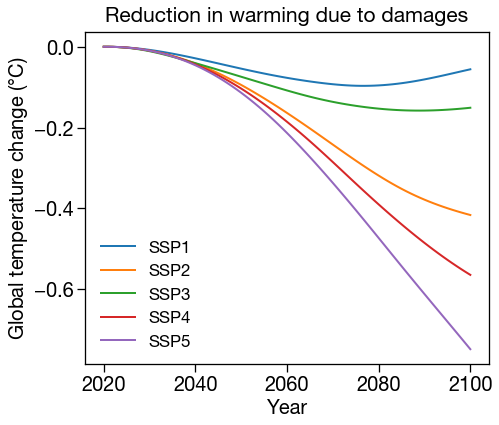

In [21]:
fig = plt.figure(figsize=(7,6))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

tfs = 21

gs0 = gridspec.GridSpec(1,1)
gs0.update(left=0.13,right=0.93,top=0.92,bottom=0.15,wspace=0.33,hspace=0.33)

ax = plt.subplot(gs0[0,0])

for x in ["SSP1","SSP2","SSP3","SSP4","SSP5"]:  
    #t1 = temp_simulated_ssps.loc[x,:,0.5] # with moderate damages
    t1 = temp_simulated_ssps.loc[x,:,1.0] # with high damages
    t2 = temp_simulated_ssps.loc[x,:,0] # without damages
    plt.plot(years,t1-t2,label=x,linewidth=2)

plt.xlabel("Year")
plt.ylabel("Global temperature change ($\degree$C)")
plt.legend(loc="lower left",frameon=False,fontsize=17)
plt.title("Reduction in warming due to damages",fontsize=tfs,pad=10)


plt.show()

In [22]:
temp_diff = temp_simulated_ssps - temp_simulated_ssps.loc[:,:,0]

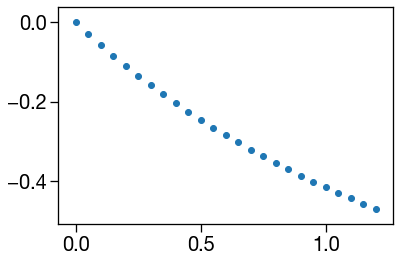

In [23]:
plt.scatter(temp_diff.damages,temp_diff.loc["SSP2",2100,:])

now let's simulate a range of TCRE and damage function values under a chosen scenario for growth rate damages

In [24]:
damage_coefs_0 = 0 # no intercept
damage_coefs_1 = np.array([np.around(x,2) for x in np.arange(0,1.5+0.05,0.05)])
damage_coefs_2 = 0 # quadratic
damage_coefs_3 = 0 # cubic

gdp_gr = xr.DataArray(np.full((len(years),len(damage_coefs_1),len(tcre_dist)),np.nan),
                          coords=[years,damage_coefs_1,tcre_dist],
                         dims=["time","damages","tcre"])
emissions_gr = xr.DataArray(np.full((len(years),len(damage_coefs_1),len(tcre_dist)),np.nan),
                          coords=[years,damage_coefs_1,tcre_dist],
                         dims=["time","damages","tcre"])
temp_gr = xr.DataArray(np.full((len(years),len(damage_coefs_1),len(tcre_dist)),np.nan),
                          coords=[years,damage_coefs_1,tcre_dist],
                         dims=["time","damages","tcre"])
damages_gr = xr.DataArray(np.full((len(years),len(damage_coefs_1),len(tcre_dist)),np.nan),
                          coords=[years,damage_coefs_1,tcre_dist],
                         dims=["time","damages","tcre"])
gdp_init = data_main.loc[data_main.year==y1,"gdp"].values[0]
emiss_init = data_main.loc[data_main.year==y1,"cumulative_emissions"].values[0]

for d in damage_coefs_1:
    dd = list(damage_coefs_1).index(d)
    print(d)
    for tt in np.arange(0,len(tcre_dist),1):
        tcre_val = tcre_dist[tt]
        cumul_emissions = data_main.cumulative_emissions.values
        dt_main = np.zeros(len(data_main.cumulative_emissions))
        dt_main[0] = gcp.loc[gcp.Year==2019,"cumulative_emissions_gtco2"].values[0]/1000.0 * tcre_val
        for j in np.arange(1,len(dt_main),1):
            dt_main[j] = cumul_emissions[j-1]/1000.0 * tcre_val
        data_main["dt"] = dt_main
        t_init = data_main.loc[data_main.year==y1,"dt"].values[0]
        gdp_gr[:,dd,tt], emissions_gr[:,dd,tt], temp_gr[:,dd,tt] = model_growth_damages(
                                                    years,gdp_init,emiss_init,
                                                    t_init,tcre_val,[damage_coefs_0,d,damage_coefs_2,damage_coefs_3],
                                                    data_main.population.values,data_main.e_g.values,
                                                    data_main.f_e.values,data_main.gdp_growth.values)

0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0
1.05
1.1
1.15
1.2
1.25
1.3
1.35
1.4
1.45
1.5


Growth and temperature with damages

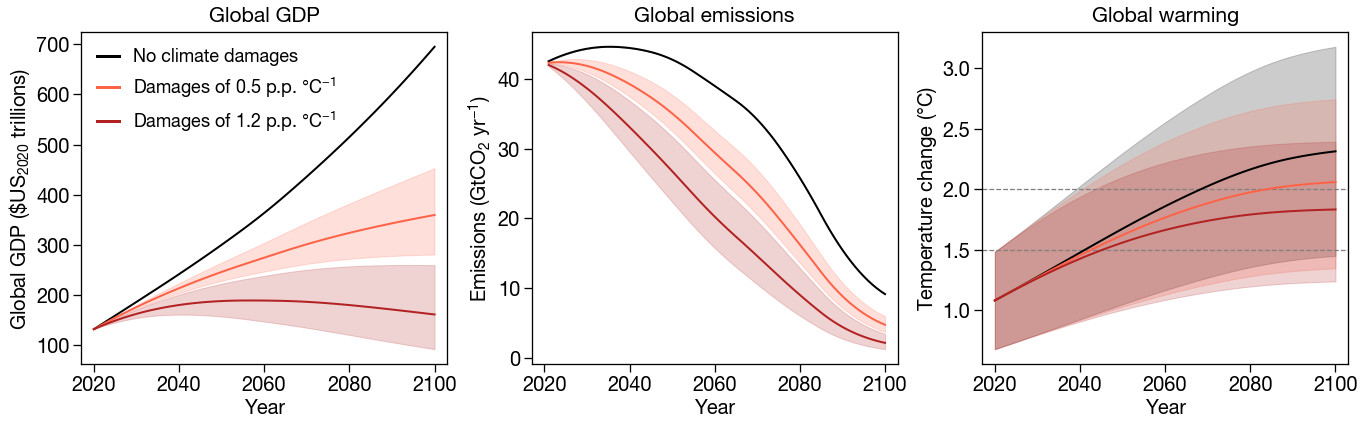

In [27]:
fig = plt.figure(figsize=(22,6))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

tfs = 21
lfs = 18
llw = 3
xl = [2017,2103]

color_no_dam = "black"
color_dam1 = "tomato" #np.array([238,119,51])/255.
color_dam2 = "firebrick" #np.array([204,51,17])/255.
time = gdp_gr.time.values

gs0 = gridspec.GridSpec(1,3)
gs0.update(left=0.13,right=0.93,top=0.92,bottom=0.15,wspace=0.23,hspace=0.33)

ax = plt.subplot(gs0[0,0])

gdp_gr_nodamage = gdp_gr.loc[:,0,:]
plt.plot(time,gdp_gr_nodamage.mean(dim="tcre"),color=color_no_dam,linewidth=2,
         label="No climate damages")

dam_levels = [0.5,1.2]
for dam_level in dam_levels:
    if dam_level==dam_levels[0]:
        col = color_dam1
    elif dam_level==dam_levels[1]:
        col = color_dam2
    gdp_gr_damage = gdp_gr.loc[:,dam_level,:]
    ax.fill_between(time,gdp_gr_damage.quantile(0.025,dim="tcre"),
                   gdp_gr_damage.quantile(0.975,dim="tcre"),color=col,alpha=0.2)
    plt.plot(time,gdp_gr_damage.mean(dim="tcre"),color=col,linewidth=2,
             label="Damages of "+str(dam_level)+" p.p. $\degree$C$^{-1}$")

plt.xlim(xl)
plt.xlabel("Year")
plt.ylabel("Global GDP (\$US$_{2020}$ trillions)")
leg = plt.legend(loc="upper left",frameon=False,fontsize=lfs,
                handlelength=1.2)
for line in leg.get_lines():
    line.set_linewidth(llw)
    
plt.title("Global GDP",fontsize=tfs,pad=10)



ax = plt.subplot(gs0[0,1])


emissions_gr_nodamage = emissions_gr.loc[:,0,:].diff(dim="time",n=1)
plt.plot(time[1:],emissions_gr_nodamage.mean(dim="tcre"),color=color_no_dam,linewidth=2)
ax.fill_between(time[1:],emissions_gr_nodamage.quantile(0.025,dim="tcre"),
                emissions_gr_nodamage.quantile(0.975,dim="tcre"),color=color_no_dam,alpha=0.2)
    
for dam_level in dam_levels:
    if dam_level==dam_levels[0]:
        col = color_dam1
    elif dam_level==dam_levels[1]:
        col = color_dam2
    emissions_gr_damage = emissions_gr.loc[:,dam_level,:].diff(dim="time",n=1)
    ax.fill_between(time[1:],emissions_gr_damage.quantile(0.025,dim="tcre"),
                   emissions_gr_damage.quantile(0.975,dim="tcre"),color=col,alpha=0.2)
    plt.plot(time[1:],emissions_gr_damage.mean(dim="tcre"),color=col,linewidth=2)


plt.xlim(xl)
plt.xlabel("Year")
plt.ylabel("Emissions (GtCO$_2$ yr$^{-1}$)")
plt.title("Global emissions",fontsize=tfs,pad=10)





ax = plt.subplot(gs0[0,2])


plt.axhline(y=1.5,color="gray",linewidth=1.3,linestyle="--")
plt.axhline(y=2.0,color="gray",linewidth=1.3,linestyle="--")

temp_gr_nodamage = temp_gr.loc[:,0,:]
plt.plot(time,temp_gr_nodamage.mean(dim="tcre"),color=color_no_dam,linewidth=2)
ax.fill_between(time,temp_gr_nodamage.quantile(0.025,dim="tcre"),
                temp_gr_nodamage.quantile(0.975,dim="tcre"),color=color_no_dam,alpha=0.2)
    
for dam_level in dam_levels:
    if dam_level==dam_levels[0]:
        col = color_dam1
    elif dam_level==dam_levels[1]:
        col = color_dam2
    temp_gr_damage = temp_gr.loc[:,dam_level,:]
    ax.fill_between(time,temp_gr_damage.quantile(0.025,dim="tcre"),
                   temp_gr_damage.quantile(0.975,dim="tcre"),color=col,alpha=0.2)
    plt.plot(time,temp_gr_damage.mean(dim="tcre"),color=col,linewidth=2)

#plt.ylim([0.95,2.8])
#plt.yticks([1,1.5,2,2.5])
plt.title("Global warming",fontsize=tfs,pad=10)
plt.ylabel("Temperature change ($\degree$C)")
plt.xlabel("Year")
plt.xlim(xl)


plt.show()

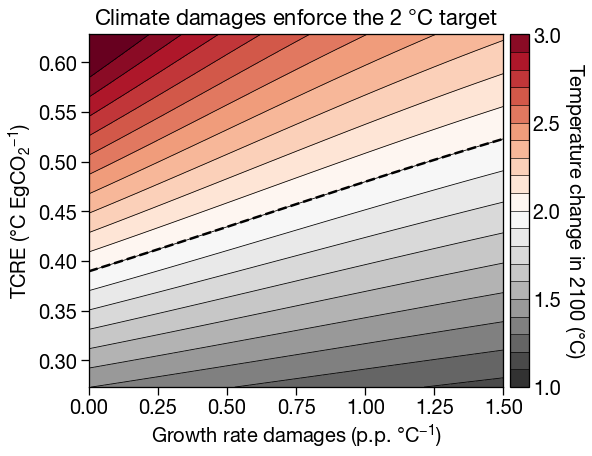

In [28]:
fig = plt.figure(figsize=(9,7))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

tfs = 22

gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.16,right=0.8,top=0.9,bottom=0.2,wspace=0.32,hspace=0.3)

ax = plt.subplot(gs1[0,0])

# colorbar
vmin = 1
vmax = 3
levels = np.arange(vmin,vmax+0.1,0.1)
ncol = len(levels)
bounds = np.linspace(vmin,vmax,ncol)

cols = plt.get_cmap('RdGy_r')(np.linspace(0,1,len(bounds)+1))
cm = colors.ListedColormap(cols[1:-1])
cm.set_over(cols[-1])
cm.set_under(cols[0])
norm = colors.Normalize(vmin=vmin,vmax=vmax)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=cm)
ext = "both"

# heatmap

damage_mesh, tcre_mesh = np.meshgrid(temp_gr.damages.values,temp_gr.tcre.values)

cs = ax.contourf(damage_mesh,tcre_mesh,
                 temp_gr[-1,:,:].transpose("tcre","damages"),
                 levels=levels,norm=norm,vmin=vmin,vmax=vmax,
            cmap=cm,extend=ext)
ax.contour(damage_mesh,tcre_mesh,temp_gr[-1,:,:].transpose("tcre","damages"),
           colors="black",alpha=1,linewidths=0.8,linestyles="solid",levels=levels)
ax.contour(damage_mesh,tcre_mesh,temp_gr[-1,:,:].transpose("tcre","damages"),
           colors="black",alpha=1,linewidths=2.5,linestyles="dashed",levels=[2],
          zorder=9)
plt.xlabel("Growth rate damages (p.p. $\degree$C$^{-1}$)")
plt.ylabel("TCRE ($\degree$C EgCO$_2$$^{-1}$)")
#plt.ylabel("Mitigation rate (GtCO$_2$ 1000EJ$^{-1}$ decade$^{-1}$)")

#plt.text(0.75,0.457,"2 $\degree$C",fontsize=18,color="black",
#        rotation=34,zorder=10,bbox=dict(facecolor="white",edgecolor="black"))

plt.title("Climate damages enforce the 2 $\degree$C target",fontsize=tfs,pad=10)
    
# plot colorbar
l = 0.81
b = 0.2
w = 0.03
h = 0.7
cbar_ax = fig.add_axes([l,b,w,h])
cb = fig.colorbar(cbar,cax=cbar_ax,orientation="vertical",
                    drawedges=True,extend="neither",
                 ticks=[1,1.5,2,2.5,3])
                 #ticks=[1.2,1.6,2,2.4,2.8])
cbar_ax.tick_params(direction="in",width=0.05,labelsize=20)

cb.set_label("Temperature change in 2100 ($\degree$C)",rotation=270,fontsize=20,
            labelpad=25)

#plt.savefig("../Figures/SelfEnforcement_Contours_v3.pdf")
plt.show()